In [1]:
import librosa
import os
import numpy as np
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

def load_audio_dataset(folder_path, target_sr=22050, n_mfcc=13, max_timesteps=125):
    audio_data = []
    labels = []
    emotions = []

    for file in os.listdir(folder_path):
        if file.endswith(".wav"):
            label = file.split("_")[0].lower()
            emotions.append(label)
            file_path = os.path.join(folder_path, file)
            signal, sr = librosa.load(file_path, sr=target_sr)
            signal, _ = librosa.effects.trim(signal)
            # 1. MFCC features
            mfcc = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=n_mfcc)
            mfcc = mfcc.T  # Transpose to shape (timesteps, n_mfcc)

            # 2. Chroma features
            chroma = librosa.feature.chroma_stft(y=signal, sr=sr)
            chroma = chroma.T  # Transpose to shape (timesteps, chroma_features)

            # 3. Spectral contrast
            spectral_contrast = librosa.feature.spectral_contrast(y=signal, sr=sr)
            spectral_contrast = spectral_contrast.T  # Transpose to shape (timesteps, spectral_features)

            # 4. RMS Energy
            rms = librosa.feature.rms(y=signal).T  # Shape (timesteps, 1)

            # 5. Zero-Crossing Rate
            zcr = librosa.feature.zero_crossing_rate(y=signal).T  # Shape (timesteps, 1)

            # Combine features
            combined_features = np.hstack((mfcc, chroma, spectral_contrast, rms, zcr))

            # Append features and labels
            audio_data.append(combined_features)
            labels.append(label)

    X = pad_sequences(audio_data, maxlen=max_timesteps, padding='post', truncating='post', dtype='float32')

    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(labels)
    y = to_categorical(y_encoded, num_classes=len(label_encoder.classes_))

    print(f"Shape of X: {X.shape}")  # (num_samples, max_timesteps, feature_dim)
    print(f"Shape of Y: {y.shape}")  # (num_samples, num_classes)
    label_map = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))
    return X, y, label_map

folder_path = "/content/drive/MyDrive/Speech_Emotion_datasets/RAVDESS_balanced_complete_dataset"

X, y, label_map = load_audio_dataset(folder_path)

print(f"Label Map: {label_map}")

Shape of X: (6048, 125, 34)
Shape of Y: (6048, 8)
Label Map: {'angry': 0, 'calm': 1, 'disgust': 2, 'fearful': 3, 'happy': 4, 'neutral': 5, 'sad': 6, 'surprised': 7}


In [2]:
from sklearn.model_selection import train_test_split

# Split into train (70%), validation (15%), and test (15%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")

Training set: (4233, 125, 34), (4233, 8)
Validation set: (907, 125, 34), (907, 8)
Test set: (908, 125, 34), (908, 8)


# Model 1 : Single layer LSTM

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, LayerNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

model1 = Sequential()
model1.add(LSTM(units=512,
               return_sequences=False,
               kernel_regularizer=l2(0.005),
               input_shape=(X_train.shape[1], X_train.shape[2])))
model1.add(Dense(units=8, activation='softmax'))
optimizer = Adam(learning_rate=0.001)
model1.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model1.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 512)                 │       1,120,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 8)                   │           4,104 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,124,360 (4.29 MB)

 Trainable params: 1,124,360 (4.29 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(model1, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)


In [ ]:
history = model1.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=100,
                    batch_size=32,
                    verbose=1)

Epoch 1/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.2569 - loss: 2.0937 - val_accuracy: 0.3881 - val_loss: 1.6911
Epoch 2/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.3960 - loss: 1.6327 - val_accuracy: 0.4487 - val_loss: 1.5155
Epoch 3/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.4322 - loss: 1.5060 - val_accuracy: 0.4344 - val_loss: 1.4719
Epoch 4/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.4653 - loss: 1.4386 - val_accuracy: 0.4245 - val_loss: 1.4915
Epoch 5/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.4681 - loss: 1.4060 - val_accuracy: 0.4730 - val_loss: 1.4081
Epoch 6/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.5124 - loss: 1.3174 - val_accuracy: 0.4553 - val_loss: 1.3917
Epoch 7/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.5068 - loss: 1.3294 - val_accuracy: 0.4807 - val_loss: 1.3209
Epoch 8/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.5220 - loss: 1.3040 - 

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

test_loss, test_accuracy = model1.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

y_pred = np.argmax(model1.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

print("\nClassification Report:")
print(classification_report(y_true, y_pred))

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6109 - loss: 1.1878
Test Loss: 1.2256
Test Accuracy: 0.5969
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.73      0.69       111
           1       0.56      0.77      0.65       107
           2       0.65      0.65      0.65       124
           3       0.51      0.41      0.45       118
           4       0.56      0.43      0.49       125
           5       0.69      0.67      0.68       106
           6       0.40      0.37      0.38       103
           7       0.70      0.76      0.73       114

    accuracy                           0.60       908
   macro avg       0.59      0.60      0.59       908
weighted avg       0.59      0.60      0.59       908



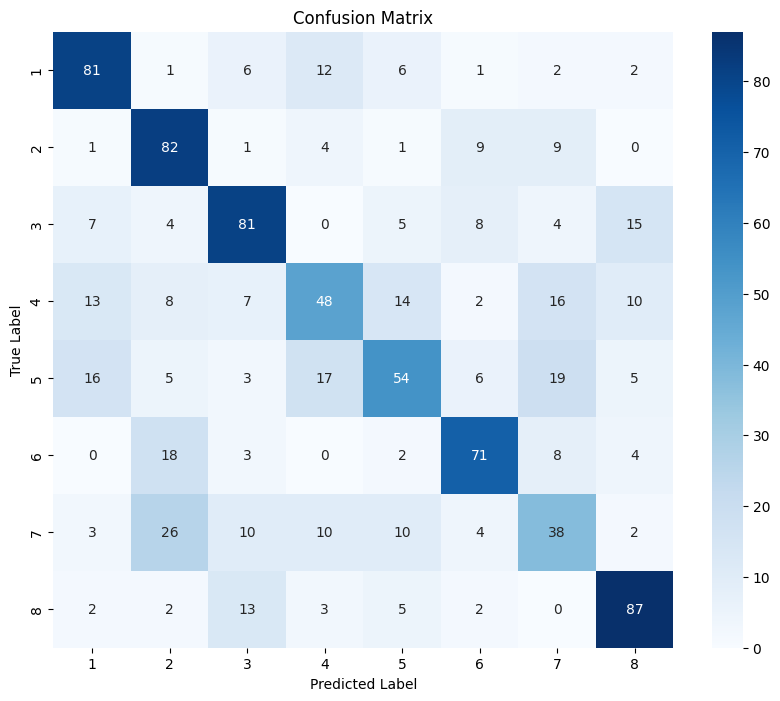

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=np.arange(1, 9), yticklabels=np.arange(1, 9))
plt.title("Confusion Matrix")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

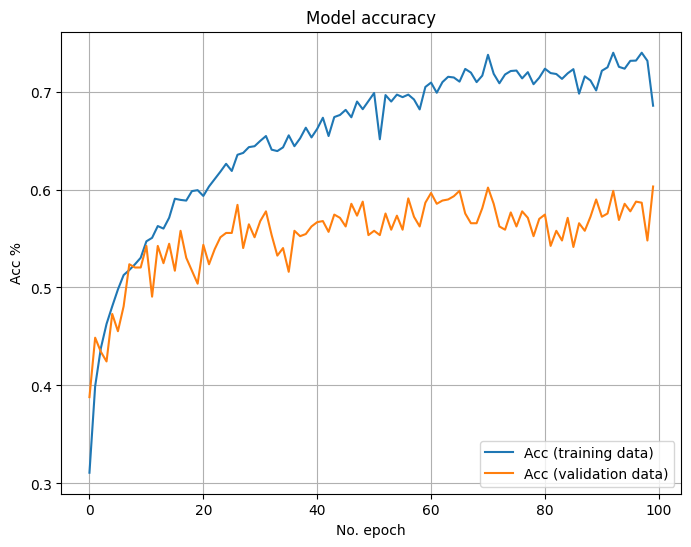

In [ ]:

# Plot accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Acc (training data)')
plt.plot(history.history['val_accuracy'], label='Acc (validation data)')
plt.title('Model accuracy')
plt.ylabel('Acc %')
plt.xlabel('No. epoch')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# Model 2 : Two layer LSTM

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, LayerNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

model2 = Sequential()
model2.add(LSTM(units=512,
               return_sequences=True,
               kernel_regularizer=l2(0.002),
               input_shape=(X_train.shape[1], X_train.shape[2])))
model2.add(Dropout(0.2))
model2.add(LSTM(units=512,
               return_sequences=False,
               kernel_regularizer=l2(0.002)))
model2.add(Dropout(0.2))
model2.add(Dense(units=8, activation='softmax'))
optimizer = Adam(learning_rate=0.001)
model2.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model2.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                        │ (None, 125, 512)            │       1,120,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 125, 512)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 512)                 │       2,099,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8)                   │           4,104 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,223,560 (12.30 MB)

 Trainable params: 3,223,560 (12.30 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model2.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=100,
                    batch_size=32,
                    verbose=1)

Epoch 1/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - accuracy: 0.2608 - loss: 2.8868 - val_accuracy: 0.3771 - val_loss: 1.8629
Epoch 2/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.3828 - loss: 1.8311 - val_accuracy: 0.4057 - val_loss: 1.6285
Epoch 3/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.4269 - loss: 1.5833 - val_accuracy: 0.4135 - val_loss: 1.5923
Epoch 4/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.4258 - loss: 1.5707 - val_accuracy: 0.4223 - val_loss: 1.5052
Epoch 5/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.4702 - loss: 1.4646 - val_accuracy: 0.4741 - val_loss: 1.4867
Epoch 6/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.4857 - loss: 1.4287 - val_accuracy: 0.4443 - val_loss: 1.4848
Epoch 7/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4744 - loss: 1.4175 - val_accuracy: 0.4961 - val_loss: 1.4232
Epoch 8/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4902 - loss: 1.398

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

test_loss, test_accuracy = model2.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

y_pred = np.argmax(model2.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

print("\nClassification Report:")
print(classification_report(y_true, y_pred))

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6670 - loss: 1.1967
Test Loss: 1.1807
Test Accuracy: 0.6685
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.75      0.73       111
           1       0.59      0.76      0.66       107
           2       0.70      0.85      0.77       124
           3       0.75      0.44      0.56       118
           4       0.70      0.65      0.68       125
           5       0.67      0.72      0.69       106
           6       0.43      0.45      0.44       103
           7       0.83      0.72      0.77       114

    accuracy                           0.67       908
   macro avg       0.67      0.67      0.66       908
weighted avg       0.68      0.67      0.67       908



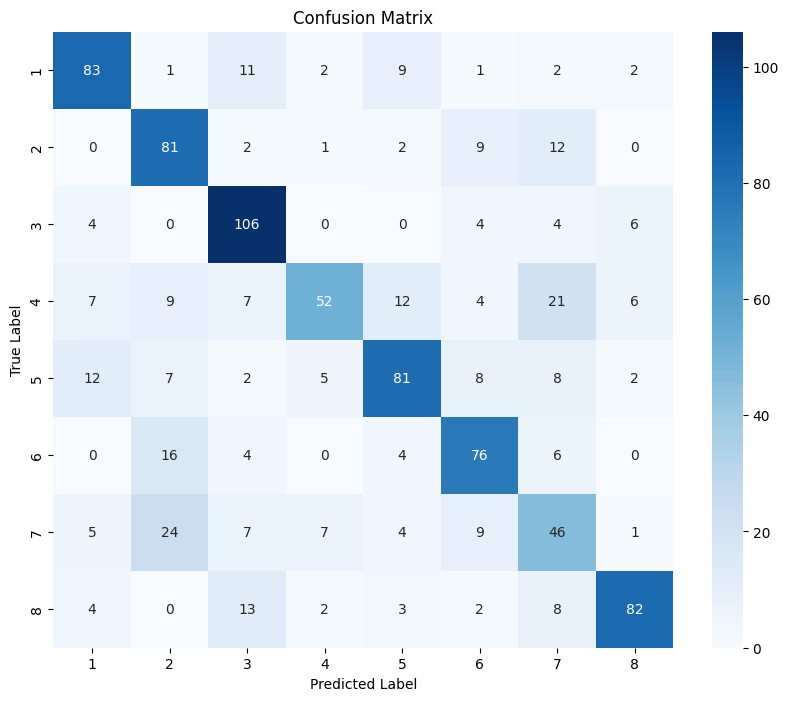

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=np.arange(1, 9), yticklabels=np.arange(1, 9))
plt.title("Confusion Matrix")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


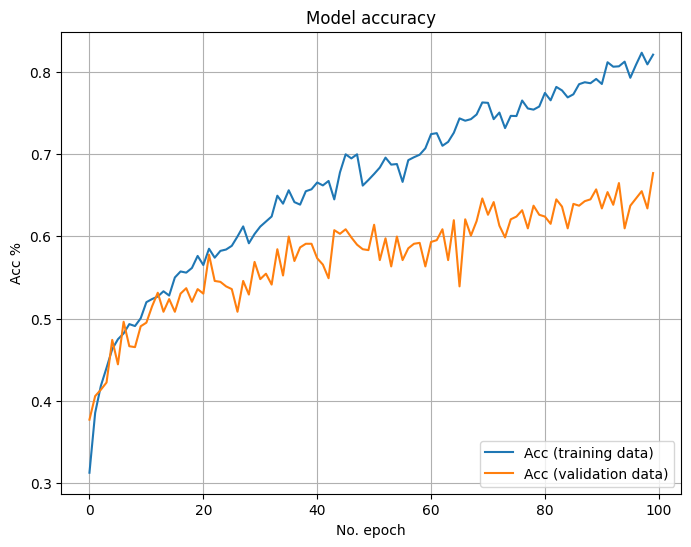

In [ ]:

# Plot accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Acc (training data)')
plt.plot(history.history['val_accuracy'], label='Acc (validation data)')
plt.title('Model accuracy')
plt.ylabel('Acc %')
plt.xlabel('No. epoch')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# Model 3 : Single layer Bi-directional LSTM

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

model3 = Sequential()
model3.add(Bidirectional(LSTM(units=512,
                             return_sequences=False,
                             kernel_regularizer=l2(0.005)),
                        input_shape=(X_train.shape[1], X_train.shape[2])))
model3.add(Dense(units=8, activation='softmax'))
optimizer = Adam(learning_rate=0.001)
model3.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
print(model3.summary())

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)        │ (None, 1024)                │       2,240,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 8)                   │           8,200 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,248,712 (8.58 MB)

 Trainable params: 2,248,712 (8.58 MB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
history = model3.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=100,
                    batch_size=32,
                    verbose=1)

Epoch 1/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.2766 - loss: 2.1689 - val_accuracy: 0.4355 - val_loss: 1.6198
Epoch 2/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.4228 - loss: 1.5762 - val_accuracy: 0.4311 - val_loss: 1.5334
Epoch 3/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.4553 - loss: 1.4687 - val_accuracy: 0.4796 - val_loss: 1.4721
Epoch 4/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.4634 - loss: 1.4220 - val_accuracy: 0.4509 - val_loss: 1.4209
Epoch 5/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.5024 - loss: 1.3534 - val_accuracy: 0.5017 - val_loss: 1.3513
Epoch 6/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.5112 - loss: 1.3154 - val_accuracy: 0.4686 - val_loss: 1.3965
Epoch 7/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.5121 - loss: 1.3174 - val_accuracy: 0.4664 - val_loss: 1.3447
Epoch 8/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.5189 - loss: 1.2827 

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

test_loss, test_accuracy = model3.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

y_pred = np.argmax(model3.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

print("\nClassification Report:")
print(classification_report(y_true, y_pred))

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6492 - loss: 1.1114
Test Loss: 1.1422
Test Accuracy: 0.6322
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.73      0.69       111
           1       0.58      0.74      0.65       107
           2       0.61      0.80      0.69       124
           3       0.51      0.55      0.53       118
           4       0.62      0.70      0.66       125
           5       0.74      0.59      0.66       106
           6       0.51      0.22      0.31       103
           7       0.88      0.67      0.76       114

    accuracy                           0.63       908
   macro avg       0.64      0.63      0.62       908
weighted avg       0.64      0.63      0.62       908



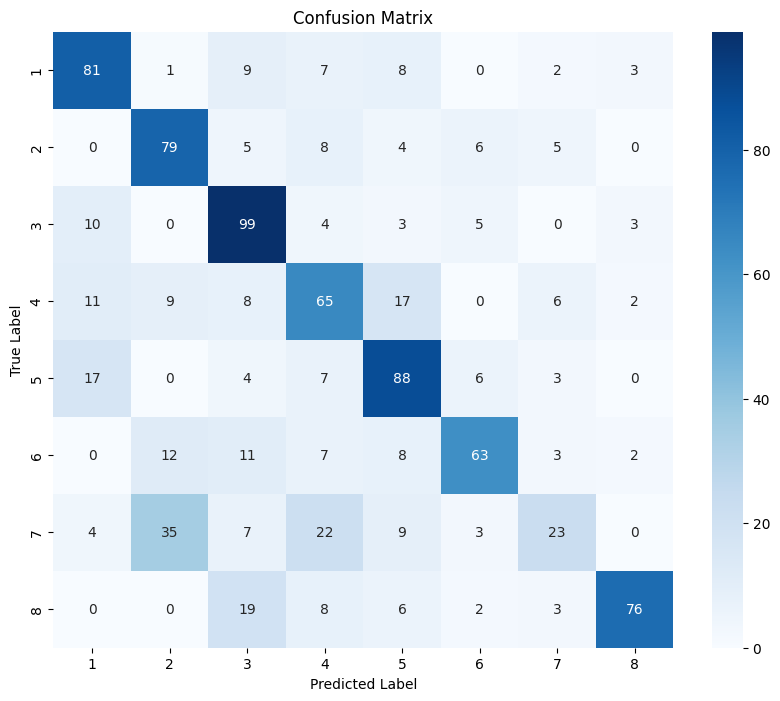

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=np.arange(1, 9), yticklabels=np.arange(1, 9))
plt.title("Confusion Matrix")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

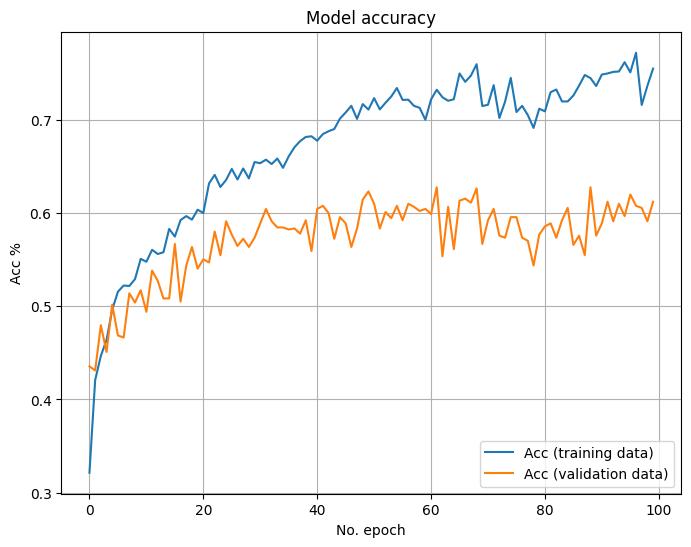

In [ ]:

# Plot accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Acc (training data)')
plt.plot(history.history['val_accuracy'], label='Acc (validation data)')
plt.title('Model accuracy')
plt.ylabel('Acc %')
plt.xlabel('No. epoch')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# Model 4 : 2 layer Bi-directional LSTM

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


model4 = Sequential()

model4.add(Bidirectional(LSTM(units=512,
                             return_sequences=True,
                             kernel_regularizer=l2(0.005)),
                        input_shape=(X_train.shape[1], X_train.shape[2])))
model4.add(Dropout(0.1))
model4.add(Bidirectional(LSTM(units=256,
                             return_sequences=False,
                             kernel_regularizer=l2(0.005))))
model4.add(Dropout(0.1))
model4.add(Dense(units=8, activation='softmax'))
optimizer = Adam(learning_rate=0.001)
model4.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


print(model4.summary())

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_1 (Bidirectional)      │ (None, 125, 1024)           │       2,240,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 125, 1024)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 512)                 │       2,623,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 8)                   │           4,104 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,868,104 (18.57 MB)

 Trainable params: 4,868,104 (18.57 MB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
history = model4.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=100,
                    batch_size=32,
                    verbose=1)

Epoch 1/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 13s 76ms/step - accuracy: 0.2396 - loss: 6.6445 - val_accuracy: 0.4024 - val_loss: 2.1060
Epoch 2/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step - accuracy: 0.3955 - loss: 2.0027 - val_accuracy: 0.4013 - val_loss: 1.8481
Epoch 3/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step - accuracy: 0.4140 - loss: 1.7818 - val_accuracy: 0.4179 - val_loss: 1.7224
Epoch 4/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - accuracy: 0.4234 - loss: 1.6677 - val_accuracy: 0.4498 - val_loss: 1.5911
Epoch 5/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - accuracy: 0.4408 - loss: 1.5863 - val_accuracy: 0.4631 - val_loss: 1.5225
Epoch 6/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - accuracy: 0.4722 - loss: 1.5037 - val_accuracy: 0.5061 - val_loss: 1.4743
Epoch 7/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 10s 71ms/step - accuracy: 0.4703 - loss: 1.5431 - val_accuracy: 0.4730 - val_loss: 1.4792
Epoch 8/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 10s 71ms/step - accuracy: 0.4745 - loss: 1

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

test_loss, test_accuracy = model4.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

y_pred = np.argmax(model4.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

print("\nClassification Report:")
print(classification_report(y_true, y_pred))

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5524 - loss: 1.3968
Test Loss: 1.3763
Test Accuracy: 0.5584
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.71      0.72       111
           1       0.51      0.54      0.53       107
           2       0.51      0.92      0.65       124
           3       0.36      0.68      0.47       118
           4       0.67      0.38      0.48       125
           5       0.96      0.46      0.62       106
           6       0.32      0.14      0.19       103
           7       0.87      0.58      0.69       114

    accuracy                           0.56       908
   macro avg       0.62      0.55      0.55       908
weighted avg       0.62      0.56      0.55       908



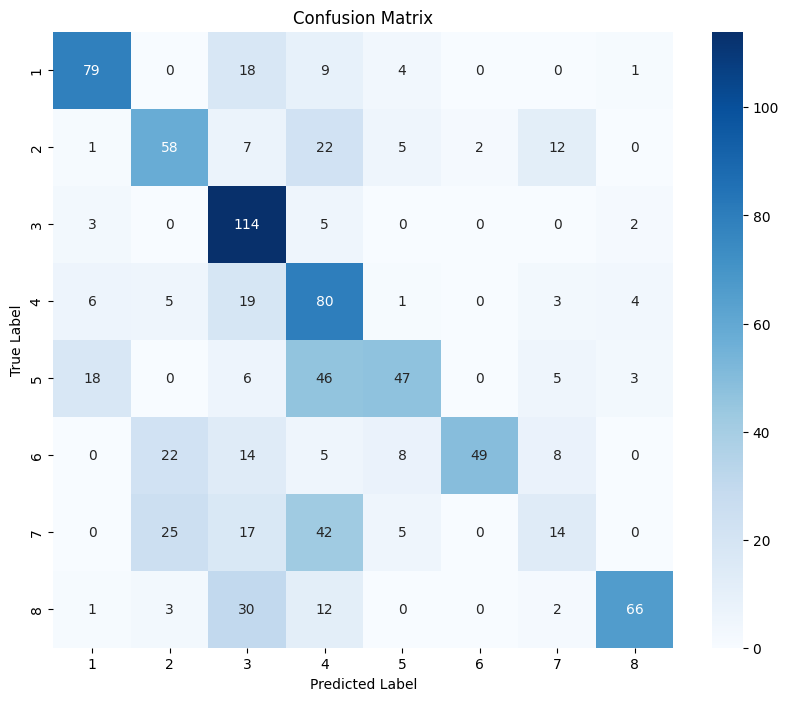

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=np.arange(1, 9), yticklabels=np.arange(1, 9))
plt.title("Confusion Matrix")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

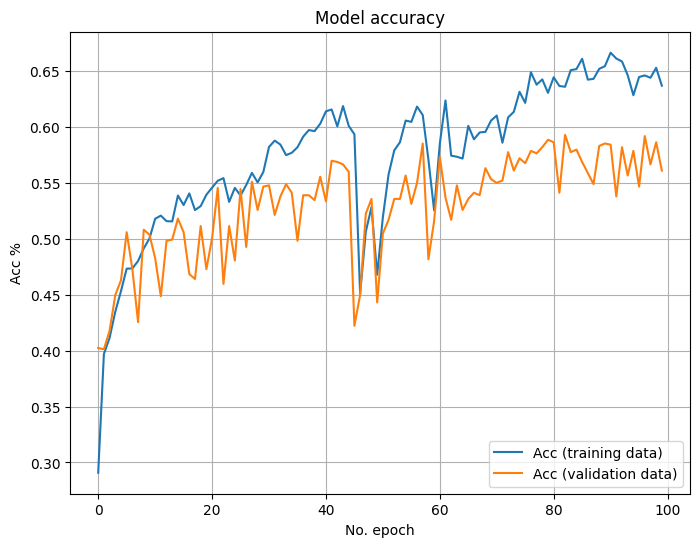

In [ ]:
# Plot accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Acc (training data)')
plt.plot(history.history['val_accuracy'], label='Acc (validation data)')
plt.title('Model accuracy')
plt.ylabel('Acc %')
plt.xlabel('No. epoch')
plt.legend(loc='lower right')
plt.grid()
plt.show()